In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from pathlib import Path

In [4]:
savepath = Path('test_samples', 'sine_samples')
savepath.mkdir(parents=True, exist_ok=True)

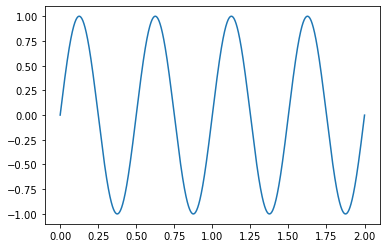

In [5]:
f = 2 # Hz
sr = 1/22050
seconds = 2
def gen_sine_wave(seconds, sr, f):
    t = np.arange(0, seconds, sr) 
    x = np.sin(2*np.pi*f*t)
    return t, x
t, x = gen_sine_wave(seconds, sr, f)
plt.plot(t, x);

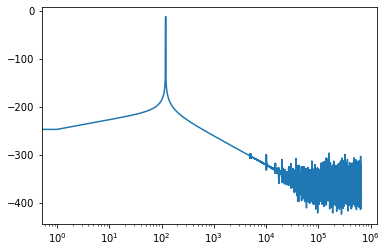

In [6]:
from scipy.fft import rfft, rfftfreq
from scipy.signal import windows

seconds=60
t, x = gen_sine_wave(seconds, sr, f)

n = x.shape[0]
win = windows.hann(n)
sxx = rfft(x*win, n=n)/n
sxx = 20*np.log10(np.abs(sxx))
freq = rfftfreq(n, 1/sr)
fig, ax = plt.subplots()
ax.plot(sxx)
ax.set_xscale('log')

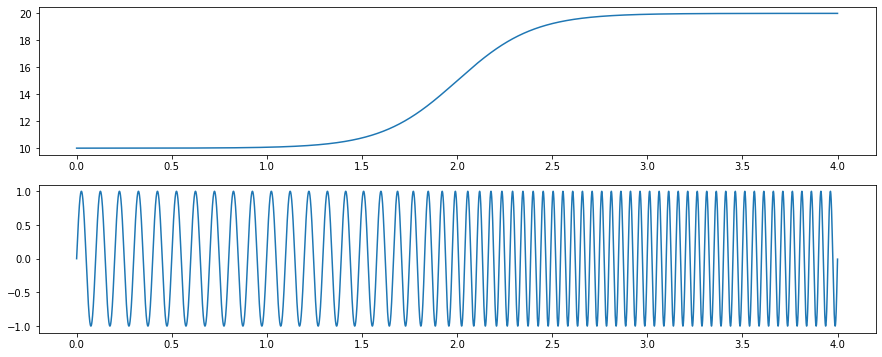

In [7]:
seconds = 4
f0, f1 = 10, 20
t_change = 2

def sigmoid(x):
    return 1./(1+np.exp(-x))

def transient_sine(seconds, sr, t_change, f0, f1, a=3):
    t = np.arange(0, seconds, sr)
    ramp = sigmoid(a*(t-t_change))
    freq = f0*(1-ramp)+f1*ramp
    phase_correction = np.add.accumulate(t*np.concatenate((np.zeros(1), 2*np.pi*(freq[:-1]-freq[1:]))))
    
    x = np.sin(2*np.pi*freq*t+phase_correction)
    return t, freq, x

t, freq, x = transient_sine(seconds, sr, t_change, f0, f1, a=5)
fig, axes = plt.subplots(nrows=2, figsize=(15,6))
axes[0].plot(t, freq)
axes[1].plot(t, x)

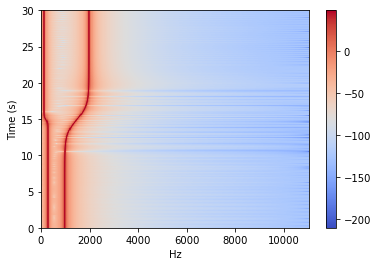

In [8]:
import librosa
import librosa.display
seconds = 60
t_change = 30
f0, f1 = 1000, 2000
t, freq, x = transient_sine(seconds, sr, t_change, f0, f1, a=0.5)

y = x.copy()

t_change = 30
f0, f1 = 300, 150
t, freq, x = transient_sine(seconds, sr, t_change, f0, f1, a=2.5)

y += x

nfft = 1024
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft, win_length=nfft)
syy = 20*np.log10(np.abs(syy))
syy = syy.transpose()
librosa.display.specshow(syy, sr=1/sr,x_axis='linear', y_axis='s')
plt.colorbar()

5.07484249068213e-09 0.9999999949251575
10.000000050748424 19.999999949251574


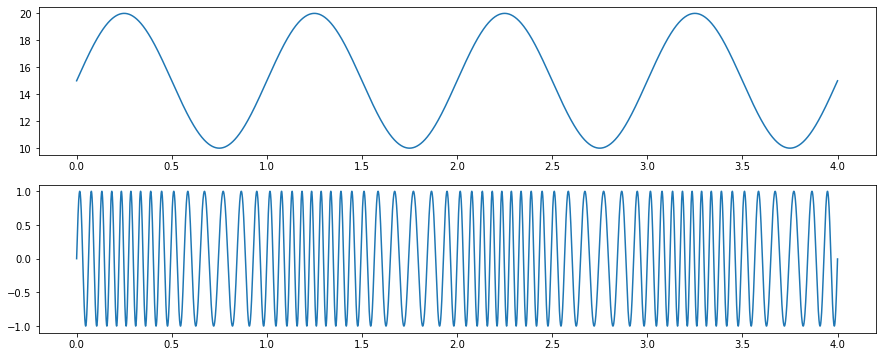

In [9]:
seconds = 4
f0, f1 = 10, 20
t_change = 2

def vibrato_sine(seconds, sr, f0, f1, v_f, v_phase=0):
    t = np.arange(0, seconds, sr)
    vibrato = (np.sin(2*np.pi*v_f*t + v_phase) + 1)/2
    print(vibrato.min(), vibrato.max())
    freq = f0 + np.abs(f1 - f0)*vibrato
    print(freq.min(), freq.max())
    phase_correction = np.add.accumulate(t*np.concatenate((np.zeros(1), 2*np.pi*(freq[:-1]-freq[1:]))))
    x = np.sin(2*np.pi*freq*t+phase_correction)
    return t, freq, x

t, freq, x = vibrato_sine(seconds, sr, f0, f1, v_f=1)
fig, axes = plt.subplots(nrows=2, figsize=(15,6))
axes[0].plot(t, freq)
axes[1].plot(t, x)

9.321139415874313e-10 0.9999999990678861
1500.0000000838902 1589.9999999161098


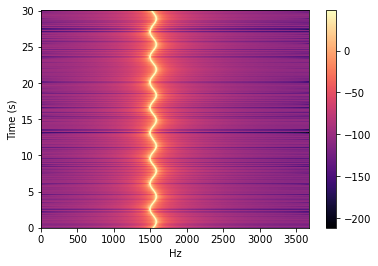

In [10]:
seconds = 60
sr=7350
f0, f1 = 1500, 1590
v_f = 1/7
t, freq, x = vibrato_sine(seconds, 1/sr, f0, f1, v_f=v_f)

y = x.copy()


nfft = 1024
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft, win_length=nfft)
syy = 20*np.log10(np.abs(syy))
syy = syy.transpose()
librosa.display.specshow(syy, sr=sr,x_axis='linear', y_axis='s')
plt.colorbar()

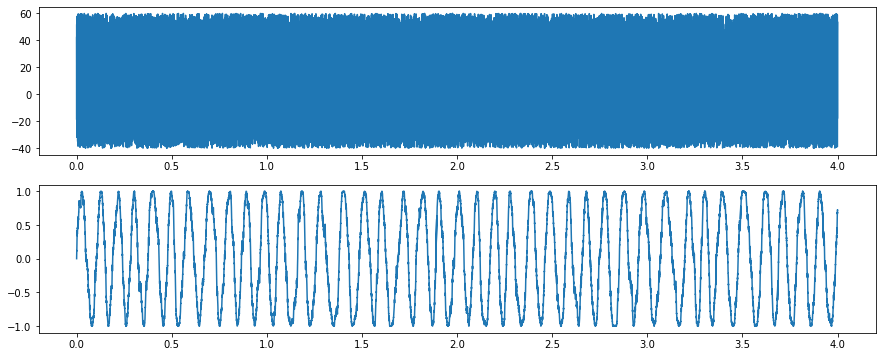

In [11]:
seconds = 4
f, w = 10, 50
t_change = 2

def noisy_sine(seconds, sr, f, w):
    t = np.arange(0, seconds, sr)
    noise = np.random.uniform(-1, 1, size=t.shape[0])
    freq = f + w*noise
    phase_correction = np.add.accumulate(t*np.concatenate((np.zeros(1), 2*np.pi*(freq[:-1]-freq[1:]))))
    x = np.sin(2*np.pi*freq*t+phase_correction)
    return t, freq, x

t, freq, x = noisy_sine(seconds, 1/sr, f, w)
fig, axes = plt.subplots(nrows=2, figsize=(15,6))
axes[0].plot(t, freq)
axes[1].plot(t, x)
plt.show()

NameError: name 'soundfile' is not defined

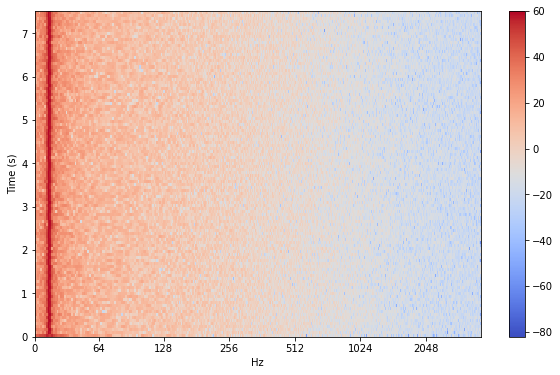

In [12]:
seconds = 60
sr=7350
f, w = 15, 20
t, freq, x = noisy_sine(seconds, 1/sr, f, w)

y = x.copy()

nfft = 4096
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft, win_length=nfft)
syy = 20*np.log10(np.abs(syy))
syy = syy.transpose()
fig, ax = plt.subplots(figsize=(10,6))
mesh = librosa.display.specshow(syy, sr=sr,x_axis='log', y_axis='s', ax=ax)
plt.colorbar(mesh)
fig.savefig(savepath / 'spectrogram.png', bbox_inches='tight')
soundfile.write(savepath / 'audio.wav', y, samplerate=22050)#, subtype= 'PCM_24')

In [ ]:
from IPython.display import Audio
Audio(savepath / 'audio.wav')

In [114]:
class FrequencyStepResponse:
    def __init__(self, responsetype, a, zeta=None):
        if responsetype not in ['1st order', '2nd order', 'sigmoid', 'ramp']:
            raise ValueError
        
        self.response = self.build_response(responsetype, a, zeta)
        
    @staticmethod
    def build_response(responsetype, a, zeta=None):
        if responsetype == '1st order':
            t_const = np.log(100)/a
            def _call(t):
                step = (t >= 0).astype('float')
                return (1 - np.e**(-t_const*t))*step
            return _call
        elif responsetype == 'sigmoid':
            aligment = 4.59512
            t_const = aligment/a
            return lambda t: sigmoid(2*t_const*t - aligment)
        elif responsetype == '2nd order':
            t_const = zeta + 1j*np.sqrt((1 - zeta**2) + 0j)
            aligment = np.log(100)/(a*np.real(t_const))
            def _call(t):
                step = (t >= 0).astype('float')
                return np.real(1 - (np.e**(-aligment*t_const*t) + np.e**(-aligment*t_const.conjugate()*t))/2)*step
            return _call
        return None
    
    def __call__(self, t):
        return self.response(t)
        

class SineTrack:
    def __init__(self, seconds, sr, f):
        t = np.arange(0, seconds, 1/sr)
        self.sr = sr
        self.t = t
        self.f = f*np.ones_like(t)
        
        self.noise      = np.zeros_like(t, dtype=np.float64)
        self.vibrato    = np.zeros_like(t, dtype=np.float64)
        
        self.phase_correction = np.zeros_like(t)
    
    def add_frequency_noise(self, w):
        t = self.t
        noise = np.random.uniform(-1, 1, size=t.shape[0])
        self.noise += w*noise
    
    def add_ripple(self, amplitude, frequency, phase):
        self.vibrato += amplitude*np.sin(2*np.pi*frequency*self.t + phase)
        
    def add_random_walk(self, t_begin, t_end, mu=0, s=1, update_cycle=1):
        size = (t_end - t_begin)*self.sr
        shocks = np.random.normal(mu, s, size//update_cycle)
        
        if update_cycle > 1:
            buffer = np.repeat(np.zeros((size//update_cycle, 1)), update_cycle - 1, axis=1) # stack number of steps withoud update
            shocks = np.concatenate([shocks[:, None], buffer], axis=1) # concatenate shock with steps without update
            shocks = shocks.flatten()                                  
        
        # pad remaining time with one more update followed by  zeros
        pad_size =  t_end*self.sr - shocks.shape[0]
        if pad_size > 0:
            shocks = np.concatenate([shocks, np.random.normal(mu, s, 1), np.zeros(pad_size -1)], axis=0)
        
        remaining_time = self.t.shape[0] - t_end*self.sr
        time_before    = t_begin*self.sr
        
        random_walk  = np.concatenate([np.zeros(time_before), shocks, np.zeros(remaining_time)])
        random_walk =  np.cumsum(random_walk)
        
        self.f += random_walk
    
    def add_transition(self, t_change, final_f, a, systemtype='sigmoid', *args, **kwargs):
        t, f = self.t, self.f
        ramp = FrequencyStepResponse(systemtype, a, *args, **kwargs)(t-t_change)
        self.f += final_f*ramp
        
    def compute(self):
        t, f = self.t, self.f
        noise, vibrato = self.noise, self.vibrato
        
        f += self.vibrato
        f += self.noise
        
        phase_correction = np.add.accumulate(t*np.concatenate((np.zeros(1), 2*np.pi*(f[:-1]-f[1:]))))
        x = np.sin(2*np.pi*f*t + phase_correction)
        return x


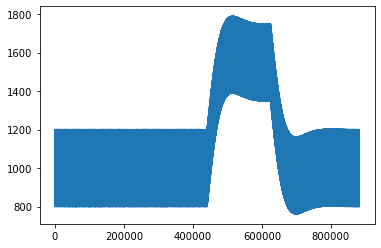

In [115]:
seconds = 120
sr = 7350
f, w = 1000, 200

track = SineTrack(seconds, sr, f)
track.add_frequency_noise(w)

t_change = 60
final_f = 1550

track.add_transition(t_change, (final_f - f), a=20, zeta=0.7, systemtype='2nd order')
track.add_transition(t_change+25, -(final_f - f), a=20, zeta=0.7, systemtype='2nd order')
# track.add_transition(t_change+25, -(final_f - f), a=7)

# track.add_ripple(50, 1/10, 0)
# track.add_ripple(25, 1/3.5, np.pi)

y = track.compute()
plt.plot(track.f)

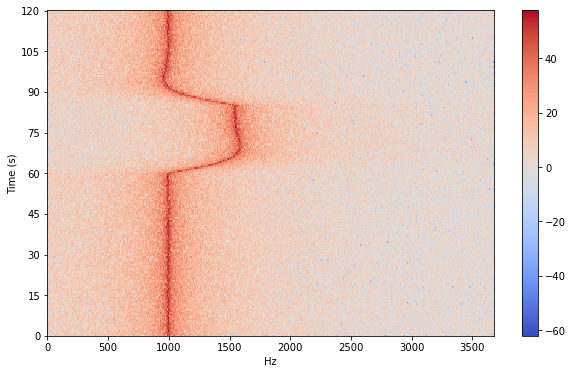

In [116]:
nfft = 4096
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft, win_length=nfft)
syy = 20*np.log10(np.abs(syy))
syy = syy.transpose()
fig, ax = plt.subplots(figsize=(10,6))
mesh = librosa.display.specshow(syy, sr=sr,x_axis='linear', y_axis='s', hop_length=nfft, ax=ax)
plt.colorbar(mesh)
fig.savefig(savepath / 'spectrogram.png', bbox_inches='tight')
# soundfile.write(savepath / 'audio.wav', y, samplerate=22050)#, subtype= 'PCM_24')

In [117]:
seconds = 120
sr = 7350
f, w = 1000, 200

track = SineTrack(seconds, sr, f)
track.add_frequency_noise(w)

t_begin, t_end = 0, 120
mu, s = 1, 10

track.add_random_walk(t_begin, t_end, mu, s, 256)

# track.add_ripple(50, 1/10, 0)
# track.add_ripple(25, 1/3.5, np.pi)

y = track.compute()

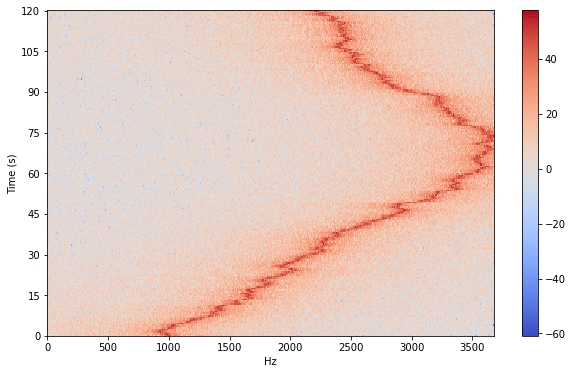

In [118]:
nfft = 4096
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft, win_length=nfft)
syy = 20*np.log10(np.abs(syy))
syy = syy.transpose()
fig, ax = plt.subplots(figsize=(10,6))
mesh = librosa.display.specshow(syy, sr=sr,x_axis='linear', y_axis='s', hop_length=nfft, ax=ax)
plt.colorbar(mesh)
fig.savefig(savepath / 'spectrogram.png', bbox_inches='tight')
# soundfile.write(savepath / 'audio.wav', y, samplerate=22050)#, subtype= 'PCM_24')

In [119]:
class TrackCollection:
    def __init__(self, track_set):
        self.set = track_set
        self.base_class =  next(iter(track_set)).__class__
        TrackCollection.set_check(self.base_class, track_set)
        
    def compute(self, reduce=True):
        tracks = np.concatenate([track.compute()[:, None] for track in self.set], axis=1)
        if reduce:
            return tracks.sum(axis=1)
        return tracks
        
    def __getattr__(self, name):
        base_methods = [method_name for method_name in dir(self)
                        if callable(getattr(self, method_name))]
        if name in base_methods:
            return getattr(self, name)
        
        base_methods = [method_name for method_name in dir(self.base_class)
                        if callable(getattr(self.base_class, method_name))]
        
        if name in base_methods:
            def partial_call(*args, **kwargs):
                return self.map_call(name, *args, **kwargs)
            return partial_call
        raise AttributeError(f"Neither {self.__class__} nor {self.base_class} objects has attribute {name}")
        
    def map_call(self, fn_name, *args, **kwargs):
        return list(map(lambda track: getattr(track, fn_name)(*args, **kwargs), self.set))
            
        
    @staticmethod
    def set_check(base_class, track_set):
        for elem in track_set:
            if not isinstance(elem, base_class):
                raise ValueError
            

In [120]:
tracks = [SineTrack(seconds, sr, f), SineTrack(seconds, sr, f+400), SineTrack(seconds, sr, f+800)]
tracks = set(tracks)
tcoll = TrackCollection(tracks)

seconds = 120
sr = 7350
f, w = 100, 50
tcoll.add_frequency_noise(w)


t_change = 40
final_f = 150

tcoll.add_transition(t_change, (final_f - f), a=80, systemtype='1st order')
# tcoll.add_transition(t_change+25, -(final_f - f), a=20, systemtype='1st order')


# track.add_ripple(50, 1/10, 0)
# track.add_ripple(25, 1/3.5, np.pi)

y = tcoll.compute()

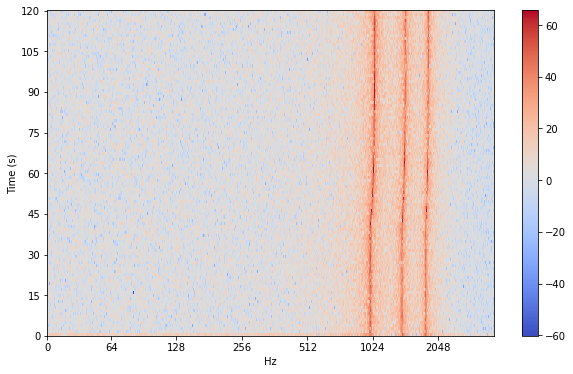

In [121]:
nfft = 8192
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft, win_length=nfft)
syy = 20*np.log10(np.abs(syy))
syy = syy.transpose()
fig, ax = plt.subplots(figsize=(10,6))
mesh = librosa.display.specshow(syy, sr=sr,x_axis='log', y_axis='s', hop_length=nfft, ax=ax)
plt.colorbar(mesh)
fig.savefig(savepath / 'spectrogram.png', bbox_inches='tight')

In [571]:
class HarmonicSequence:
    def __init__(self, seconds, sr, fundamental, jump, power_fn=None, fmax=1000):
        tracks = list()
        freq = fundamental*jump
        c = 2
        if power_fn is not None:
            power_curve = list()
            power_curve.append(power_fn(freq))
        else:
            power_curve = None
        tracks.append(SineTrack(seconds, sr, freq))
        while freq <= fmax:
            print(freq)
            freq = fundamental*jump*c
            c += 1
            if power_fn is not None:
                power_curve.append(power_fn(freq))
            tracks.append(SineTrack(seconds, sr, freq))
        self.track_set = TrackCollection(tracks)
        self.power_curve = power_curve
        
    def compute(self):
        if self.power_curve is not None:
            tracks = self.track_set.compute(reduce=False)
            power_curve = np.array(self.power_curve)[None, :]
            return (tracks*power_curve[:, ::1]).sum(axis=1)
        return self.track_set.compute()
        

In [129]:
from scipy.interpolate import interp1d
import librosa.util as util
import librosa
from scipy.signal.windows import hann
import numpy as np
import pandas as pd

from scipy.fft import rfft, irfft, rfftfreq
from scipy.signal import windows
import librosa.util as util

sea_state = pd.read_csv('sea_state.txt', delimiter=' ')
shipping_noise = pd.read_csv('shipping_noise.txt', delimiter=' ')
rain_noise = pd.read_csv('rain_noise.txt', delimiter=';')

sea_state.set_index('Frequency', inplace=True)
shipping_noise.set_index('Frequency', inplace=True)
rain_noise.set_index('Frequency', inplace=True)


def sim_noise(nsamples, sr, noise_curve):
    wnoise = np.random.normal(0.0, 1., size=nsamples)
#     wnoise_img = np.random.uniform(0.8, 1.2, size=nsamples//2 + 1)
    sxx_w = rfft(wnoise)
#     sxx_w = wnoise + 1j*wnoise_img
    freqs = rfftfreq(nsamples, d=1/sr)
    

    sxx_p = sxx_w.copy()
    sxx_w = (sxx_w - sxx_w.mean())/sxx_w.std()
#     sxx_w = util.normalize(sxx_w)
    sxx_p = sxx_w*(10**(noise_curve(freqs)/20))
#     sxx_p[freqs < 200] = 0
    pnoise = irfft(sxx_p)
    return pnoise, sxx_p, noise_curve, freqs

def sea_noise(nsamples, sr, state=1):
    y = sea_state[f"SS{state}"].values
    x = sea_state.index.values
    noise_curve = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    return sim_noise(nsamples, sr, noise_curve)

def ship_noise(nsamples, sr, state=1):
    y = shipping_noise[f"SL{state}"].values
    x = shipping_noise.index.values
    noise_curve = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    return sim_noise(nsamples, sr, noise_curve)

[59.4        59.58666667 59.77333333 ... 25.40009333 25.40004667
 25.4       ]
[787.38737739-1.36757686e+00j 776.72689426+7.91359789e+02j
   2.42650177-4.54267335e+02j ...   1.32651124-1.27552918e+01j
   2.76661199-9.25580369e+00j -30.73660119-2.72867457e-02j]


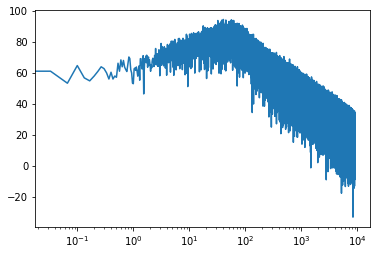

In [470]:
seconds=30
sr=18000
nfft=8192
state = 6
noise, sxx_p, sea_state_curve, freqs = ship_noise(seconds*sr, sr, state=state)
fig, ax = plt.subplots()
# ax.plot(sxx_w)
print(sxx_p)
ax.plot(freqs, 20*np.log10(np.abs(sxx_p)))
ax.set_xscale('log')

sxx = rfft(noise)/(noise.shape[0])
sxx = np.abs(sxx)

43.0
86.0


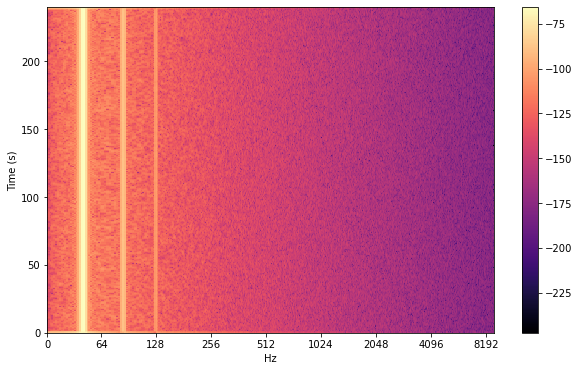

In [605]:
hsequence = HarmonicSequence(seconds, sr, 430/60, 6, lambda f: 1/f**4, fmax=100)
f, w = 100, 1
# hsequence.track_set.add_frequency_noise(w)
y = hsequence.compute()

nfft = 8192
# y = util.normalize(np.abs(y), norm=2)
y = y + (1/800000000)*noise
syy = librosa.stft(y, n_fft=nfft, hop_length=nfft//8, win_length=nfft)
syy_noise = librosa.stft(noise, n_fft=nfft, hop_length=nfft//8, win_length=nfft)
freqs = librosa.fft_frequencies(sr=sr, n_fft=nfft)
ship_curve = np.repeat(sea_state_curve(freqs)[:, None], syy.shape[1], axis=1)
# syy = syy*(10**(ship_curve/20))


# y_fft = (10*(syy_power + 1j*np.angle(syy)) + syy_noise)

# y = librosa.istft(y_fft, hop_length=nfft//8, win_length=nfft)


syy_phase = np.angle(syy)
syy = 20*np.log10(np.abs(syy))


syy_noise = 20*np.log10(np.abs(syy_noise))
# syy_noise[syy > -30] = syy_noise.min()
# syy *= ship_curve

# y = librosa.griffinlim(syy + 1j*syy_phase, n_iter=256, hop_length=nfft//8, win_length=nfft, init=None)

syy = syy.transpose()
syy_noise = syy_noise.transpose()

fig, ax = plt.subplots(figsize=(10,6))
mesh = librosa.display.specshow(syy, sr=sr,x_axis='log', y_axis='s', hop_length=nfft, ax=ax)
plt.colorbar(mesh)
fig.savefig(savepath / 'spectrogram.png', bbox_inches='tight')



6.57881455141156


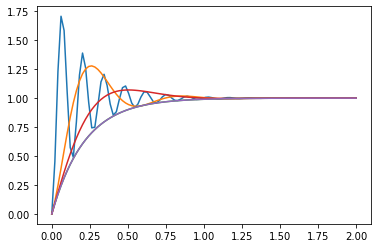

In [32]:
t = np.linspace(0, 2, 100)

zeta = 0.1


t_const = zeta + 1j*np.sqrt(1 - zeta**2)
adjust = np.log(100)/np.real(t_const)
response = 1 - (np.e**(-adjust*t_const*t) + np.e**(-adjust*t_const.conjugate()*t))/2
plt.plot(t, np.real(response))


zeta = 0.4



t_const = zeta + 1j*np.sqrt(1 - zeta**2)
adjust = np.log(100)/np.real(t_const)
response = 1 - (np.e**(-adjust*t_const*t) + np.e**(-adjust*t_const.conjugate()*t))/2
plt.plot(t, np.real(response))

zeta = 1.0 

t_const = zeta + 1j*np.sqrt(1 - zeta**2)
adjust = np.log(100)/np.real(t_const)
response = 1 - (np.e**(-adjust*t_const*t) + np.e**(-adjust*t_const.conjugate()*t))/2
plt.plot(t, np.real(response))

zeta = 0.7 

t_const = zeta + 1j*np.sqrt(1 - zeta**2)
adjust = np.log(100)/np.real(t_const)
response = 1 - (np.e**(-adjust*t_const*t) + np.e**(-adjust*t_const.conjugate()*t))/2
plt.plot(t, np.real(response))

zeta = 1.5

print(adjust)
t_const = zeta + 1j*np.sqrt((1 - zeta**2) + 0j)
adjust = np.log(100)/np.real(t_const)

response = 1 - (np.e**(-adjust*t_const*t) + np.e**(-adjust*t_const.conjugate()*t))/2
plt.plot(t, np.real(response))


# response = 1 - (np.e**(-t))
# plt.plot(t, np.real(response))